In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the auction dataset (assuming you have the dataset in CSV format)
auction_data = pd.read_csv('auction.csv')

# Data Pre-Processing

In [3]:
# 1. Handle Missing Values
# Check for missing values
print(auction_data.isnull().sum())

auctionid        0
bid              0
bidtime          0
bidder          16
bidderrate      11
openbid          0
price            0
item             0
auction_type     0
dtype: int64


In [5]:
auction_data['bid'] = pd.to_numeric(auction_data['bid'], errors='coerce')
auction_data.head()

,auctionid,bid,bidtime,bidder,bidderrate,openbid,price,item,auction_type
0,1638893549,175.0,2.230949,schadenfreud,0.0,99.0,177.5,Cartier wristwatch,3 day auction
1,1638893549,100.0,2.600116,chuik,0.0,99.0,177.5,Cartier wristwatch,3 day auction
2,1638893549,120.0,2.600810,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
3,1638893549,150.0,2.601076,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
4,1638893549,177.5,2.909826,eli.flint@flightsafety.co,4.0,99.0,177.5,Cartier wristwatch,3 day auction


In [11]:
print(auction_data['auctionid'].dtype)

int64


In [9]:
# Fill missing values or drop rows/columns with missing data
# Example: Filling missing numerical columns with the mean and categorical with the mode
auction_data['bidder'].fillna(auction_data['bidder'].mode()[0], inplace=True)
auction_data['bidderrate'].fillna(auction_data['bidderrate'].mean(), inplace=True)

In [10]:
print(auction_data.isnull().sum())
auction_data.head()

auctionid       0
bid             0
bidtime         0
bidder          0
bidderrate      0
openbid         0
price           0
item            0
auction_type    0
dtype: int64


,auctionid,bid,bidtime,bidder,bidderrate,openbid,price,item,auction_type
0,1638893549,175.0,2.230949,schadenfreud,0.0,99.0,177.5,Cartier wristwatch,3 day auction
1,1638893549,100.0,2.600116,chuik,0.0,99.0,177.5,Cartier wristwatch,3 day auction
2,1638893549,120.0,2.600810,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
3,1638893549,150.0,2.601076,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
4,1638893549,177.5,2.909826,eli.flint@flightsafety.co,4.0,99.0,177.5,Cartier wristwatch,3 day auction


In [12]:
# 2. Convert Data Types
# Convert 'auctionid' and 'bidder' to string to ensure they are treated as categorical identifiers
auction_data['auctionid'] = auction_data['auctionid'].astype(str)
auction_data['bidder'] = auction_data['bidder'].astype(str)

In [13]:
# 3. Feature Engineering
# Create new features that could be helpful for detecting collusion or suspicious behavior:
# 3.1 Bidder Frequency: Count of bids placed by each bidder
auction_data['bidder_frequency'] = auction_data.groupby('bidder')['bid'].transform('count')

# 3.2 Time Gap Between Bids: Difference in bid time between consecutive bids by the same bidder
auction_data['bidtime_diff'] = auction_data.groupby('bidder')['bidtime'].diff().fillna(0)

# 3.3 Price Deviation: Difference between final price and opening bid
auction_data['price_deviation'] = auction_data['price'] - auction_data['openbid']

# 3.4 Average Bid: Calculate the average bid placed by each bidder
auction_data['avg_bid'] = auction_data.groupby('bidder')['bid'].transform('mean')

# 4. Check the processed data
print(auction_data.head())

# 5. Save the cleaned and feature-engineered data to a new CSV file
auction_data.to_csv('auction_cleaned.csv', index=False)

    auctionid    bid   bidtime                     bidder  bidderrate  \
0  1638893549  175.0  2.230949               schadenfreud         0.0   
1  1638893549  100.0  2.600116                      chuik         0.0   
2  1638893549  120.0  2.600810                 kiwisstuff         2.0   
3  1638893549  150.0  2.601076                 kiwisstuff         2.0   
4  1638893549  177.5  2.909826  eli.flint@flightsafety.co         4.0   

   openbid  price                item   auction_type  bidder_frequency  \
0     99.0  177.5  Cartier wristwatch  3 day auction                 1   
1     99.0  177.5  Cartier wristwatch  3 day auction                 1   
2     99.0  177.5  Cartier wristwatch  3 day auction                 2   
3     99.0  177.5  Cartier wristwatch  3 day auction                 2   
4     99.0  177.5  Cartier wristwatch  3 day auction                 1   

   bidtime_diff  price_deviation  avg_bid  
0      0.000000             78.5    175.0  
1      0.000000             

# DBScan

In [14]:
from sklearn.cluster import DBSCAN
import numpy as np

# Selecting the features you want to use for DBSCAN (based on your engineered features)
features = ['bidder_frequency', 'bidtime_diff', 'price_deviation', 'avg_bid']

# Standardizing the data for better clustering performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(auction_data[features])

In [15]:
print(scaled_features)

[[-0.83542649 -0.14762085 -0.53839464 -0.1044352 ]
 [-0.83542649 -0.14762085 -0.53839464 -0.34480265]
 [-0.71180235 -0.14762085 -0.53839464 -0.23263117]
 ...
 [-0.58817821 -0.68219183 -0.50808814 -0.38219314]
 [-0.71180235 -0.05410958 -0.50808814 -0.37204429]
 [-0.83542649 -0.14762085 -0.50808814 -0.37681959]]


In [28]:
# Applying DBSCAN
#eps => the maximum distance between two points for them to be considered as part of the same neighborhood
#min_samples => minimum number of points required to form a dense region

dbscan = DBSCAN(eps=0.5, min_samples=5)
auction_data['dbscan_cluster'] = dbscan.fit_predict(scaled_features)

# The 'dbscan_cluster' column will now contain cluster labels or -1 for outliers (noise)
#These bidders may be engaging in suspicious behavior, such as placing unusually high or low bids at strategic times.

print(auction_data[['bidder', 'dbscan_cluster']].head())

                      bidder  dbscan_cluster
0               schadenfreud               0
1                      chuik               0
2                 kiwisstuff               0
3                 kiwisstuff               0
4  eli.flint@flightsafety.co               0


In [19]:
# print(auction_data[['bidder', 'dbscan_cluster']])

In [29]:
print(auction_data['dbscan_cluster'].value_counts())

 0     10029
-1       373
 25       51
 2        37
 1        20
 8        14
 5        12
 15       12
 21       11
 7        11
 3        11
 22       10
 13        8
 12        7
 4         7
 9         6
 6         6
 19        6
 10        5
 14        5
 16        5
 17        5
 18        5
 20        5
 11        5
 23        5
 24        5
 26        5
Name: dbscan_cluster, dtype: int64


In [20]:
outliers = auction_data[auction_data['dbscan_cluster'] == -1]
print(outliers.head())

      auctionid    bid   bidtime        bidder  bidderrate  openbid   price  \
55   1643075711  500.0  0.250718  restdynamics         0.0    200.0  1225.0   
59   1643075711  700.0  0.554294      lass1004         3.0    200.0  1225.0   
64   1643075711  790.0  1.252813  restdynamics         0.0    200.0  1225.0   
65   1643075711  810.0  1.252998  restdynamics         0.0    200.0  1225.0   
101  1643885624  175.0  2.836910     trunkbath         0.0    100.0   326.0   

                   item   auction_type  bidder_frequency  bidtime_diff  \
55   Cartier wristwatch  3 day auction                27      0.000000   
59   Cartier wristwatch  3 day auction                29      0.000000   
64   Cartier wristwatch  3 day auction                27      1.002095   
65   Cartier wristwatch  3 day auction                27      0.000185   
101  Cartier wristwatch  3 day auction                14      0.000000   

     price_deviation     avg_bid  dbscan_cluster  
55            1025.0  787.407

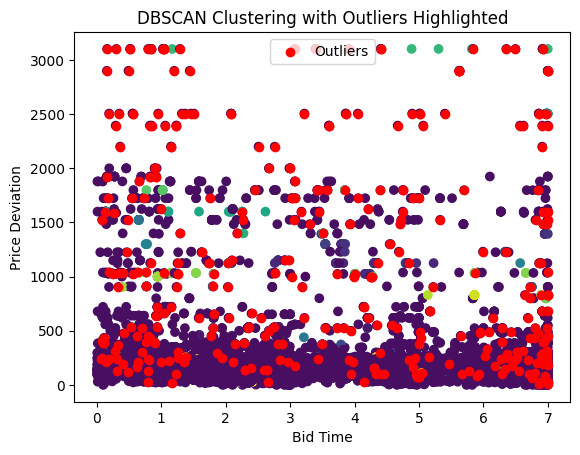

In [21]:
import matplotlib.pyplot as plt

# Scatter plot showing clusters and outliers
plt.scatter(auction_data['bidtime'], auction_data['price_deviation'], c=auction_data['dbscan_cluster'], cmap='viridis')
plt.scatter(outliers['bidtime'], outliers['price_deviation'], color='red', label='Outliers')
plt.xlabel('Bid Time')
plt.ylabel('Price Deviation')
plt.legend()
plt.title('DBSCAN Clustering with Outliers Highlighted')
plt.show()


# Z-Score for Outlier Detection

In [30]:
from scipy.stats import zscore

# Calculate Z-Score for the bid column
auction_data['bid_zscore'] = zscore(auction_data['bid'])

# Flag suspicious bidders where the absolute Z-score is greater than 3 (considered as outliers)
suspicious_bidders = auction_data[auction_data['bid_zscore'].abs() > 3]

# Output the suspicious bidders
print(suspicious_bidders[['bidder', 'bid', 'bid_zscore']])

                  bidder     bid  bid_zscore
68               6969.ca  1225.0    3.149671
69    gm492@columbia.edu  1200.0    3.072277
160           pereluzi00  1210.0    3.103235
161           barginbook  1500.0    4.001005
162           pereluzi00  1260.0    3.258023
...                  ...     ...         ...
1921             hjg6593  1200.0    3.072277
1922             hjg6593  1800.0    4.929734
1923          rplfunding  2800.0    8.025496
1924             alexiku  3000.0    8.644648
1925          rplfunding  3050.0    8.799436

[304 rows x 3 columns]


In [34]:
# Count the number of suspicious bidders based on Z-score outlier detection
suspicious_bidders_count = suspicious_bidders.shape[0]
print(f'Number of suspicious bidders: {suspicious_bidders_count}')
print(f'Percentage of suspicious bidders: {(suspicious_bidders_count/auction_data.shape[0])*100:.2f}%')

Number of suspicious bidders: 304
Percentage of suspicious bidders: 2.85%


# Collusion and Bid-Rigging Detection Logic

### Price Deviation Analysis

In [44]:
# Combine DBSCAN cluster labels and statistical outlier detection (Z-Score and Price Deviation)
potential_collusion = auction_data[
    (auction_data['dbscan_cluster'] != -1) &  # DBSCAN clusters (not noise, i.e., -1)
    (auction_data['bid_zscore'].abs() > 3)  # Z-Score outliers
]
# Output potential collusion suspects
print(potential_collusion[['bidder', 'auctionid', 'bid', 'bid_zscore', 'dbscan_cluster']])
print(f'Number of potential colluders: {potential_collusion.shape[0]}')

                  bidder   auctionid     bid  bid_zscore  dbscan_cluster
68               6969.ca  1643075711  1225.0    3.149671               0
69    gm492@columbia.edu  1643075711  1200.0    3.072277               0
163           pereluzi00  1646353713  1310.0    3.412811               1
164           pereluzi00  1646353713  1360.0    3.567599               1
165           pereluzi00  1646353713  1460.0    3.877175               1
...                  ...         ...     ...         ...             ...
1803             rrsumba  1649718196  1799.0    4.926638               0
1860            strongob  1649944294  1200.0    3.072277               0
1861            strongob  1649944294  1300.0    3.381853               0
1862            strongob  1649944294  1400.0    3.691429               0
1864         boxsterbear  1649944294  1460.0    3.877175               0

[181 rows x 5 columns]
Number of potential colluders: 181


### Bidder Frequency and Time Gap Analysis

In [45]:
# Apply the threshold for price deviation, time gap, and frequency
price_threshold = 100  
time_gap_threshold = 10 
frequency_threshold = 5 

# Filter potential collusion based on DBSCAN, Z-score, and price deviation
potential_collusion = auction_data[
    (auction_data['dbscan_cluster'] != -1) &  # DBSCAN clusters (not noise, i.e., -1)
    (auction_data['bid_zscore'].abs() > 3) &  # Z-Score outliers
    (auction_data['price_deviation'] > price_threshold)  # Price deviation threshold
]

# Filter based on suspicious bidder behavior: frequency and time gaps
suspicious_time_gap_bidders = auction_data[auction_data['bidtime_diff'] < time_gap_threshold]
suspicious_bidder_frequency = auction_data[auction_data['bidder_frequency'] > frequency_threshold]

# Combine the results from all filters
suspicious_bidders = potential_collusion[
    (potential_collusion['bidder'].isin(suspicious_time_gap_bidders['bidder'])) |  # Time gap-based suspicion
    (potential_collusion['bidder'].isin(suspicious_bidder_frequency['bidder']))  # Frequency-based suspicion
]

# Print the final suspicious bidders
print(suspicious_bidders[['bidder', 'auctionid', 'bid', 'price_deviation', 'bid_zscore', 'bidtime_diff', 'dbscan_cluster']])
print(f'Number of potential colluders: {suspicious_bidders.shape[0]}')

                  bidder   auctionid     bid  price_deviation  bid_zscore  \
68               6969.ca  1643075711  1225.0           1025.0    3.149671   
69    gm492@columbia.edu  1643075711  1200.0           1025.0    3.072277   
163           pereluzi00  1646353713  1310.0            535.0    3.412811   
164           pereluzi00  1646353713  1360.0            535.0    3.567599   
165           pereluzi00  1646353713  1460.0            535.0    3.877175   
...                  ...         ...     ...              ...         ...   
1803             rrsumba  1649718196  1799.0           1798.0    4.926638   
1860            strongob  1649944294  1200.0           1484.0    3.072277   
1861            strongob  1649944294  1300.0           1484.0    3.381853   
1862            strongob  1649944294  1400.0           1484.0    3.691429   
1864         boxsterbear  1649944294  1460.0           1484.0    3.877175   

      bidtime_diff  dbscan_cluster  
68        0.000000               0  
6